## Предсказание ковидных спайков


Данные обрабатываются как временной ряд, т.е. на основании нескольких значений предсказывается следующее.

Используется длинна последовательности = 8.

In [ ]:
#Загружаем библиотеки
import numpy as np
import pandas as pd 

#Оптимизатор
from tensorflow.keras.optimizers import Adam, SGD
# Модели
from tensorflow.keras.models import Sequential, Model 
# Чтобы сохранять модель
from tensorflow.keras.models import load_model, save_model
# Стандартные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM 
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Lambda, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D
# Нормирование
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# Чтобы сохранять стандарт скейлер
from joblib import dump, load

from tensorflow.keras import utils #отсюда to_categorical
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator #генерация выборки временных рядов
from tensorflow.keras.utils import plot_model 

import keras.backend as K    
from keras.losses import MAE 

import time
import random as random
from google.colab import files


#Отрисовка графиков
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
#подключаем диск 
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/my_data/CardioSpike/'
!ls {PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'AK&VGG16'		 test.csv	       true_values.npy
 Checkpoint.hdf5	'Time series N->N+1'
 sample_submission.csv	 train.csv


In [ ]:
# Загружаем данные
base_data = pd.read_csv(PATH + 'train.csv', sep=',')

In [ ]:
base_data

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0
...,...,...,...,...
60482,275,115360,552,0
60483,275,115912,552,0
60484,275,116464,552,0
60485,275,117020,556,0


In [ ]:
# обнаружили выбросы
base_data[base_data['x']>5000]

In [ ]:
# удалим выбросы
# base_data = base_data.loc[base_data['x'] < 5000]
# base_data[base_data['x']>5000]

,id,time,x,y


In [ ]:
# данные для обучения
# data = base_data.loc[:55000]
data = base_data.copy()
data.tail()

,id,time,x,y
60482,275,115360,552,0
60483,275,115912,552,0
60484,275,116464,552,0
60485,275,117020,556,0
60486,275,117572,552,0


**Работаем с переразмеченным Y**

In [ ]:
true_values = np.load(PATH + 'true_values.npy')
data['y_new'] = true_values
data.head()

,id,time,x,y,y_new
0,1,0,800,0,0.0
1,1,780,780,0,0.0
2,1,1572,792,0,0.0
3,1,2392,820,0,0.0
4,1,3196,804,0,0.0


In [ ]:
# Готовим данные

# скопируем столбец x со сдвигом
data['x(i-1)'] =  data['x'].shift(1)
data['x(i-2)'] =  data['x'].shift(2)
data['x(i+1)'] =  data['x'].shift(-1)

data['dx1'] =  data['x(i-1)'] - data['x(i-2)']
data['dx2'] =  data['x'] - data['x(i-1)'] 
data['dx3'] =  data['x(i+1)'] - data['x']

# скопируем time
data['time(i-1)'] =  data['time'].shift(1)
data['time(i-2)'] =  data['time'].shift(2)
data['time(i+1)'] =  data['time'].shift(-1)

data['dt1'] =  data['time(i-1)'] - data['time(i-2)']
data['dt2'] =  data['time'] - data['time(i-1)'] 
data['dt3'] =  data['time(i+1)'] - data['time']

# удаляем ненужные толбцы
del data['id']
del data['time']
del data['x']

del data['x(i-1)']  
del data['x(i-2)']  
del data['x(i+1)']

del data['time(i-1)']  
del data['time(i-2)']
del data['time(i+1)']


In [ ]:
data.head()

,y,y_new,dx1,dx2,dx3,dt1,dt2,dt3
0,0,0.0,NaN,NaN,-20.0,NaN,NaN,780.0
1,0,0.0,NaN,-20.0,12.0,NaN,780.0,792.0
2,0,0.0,-20.0,12.0,28.0,780.0,792.0,820.0
3,0,0.0,12.0,28.0,-16.0,792.0,820.0,804.0
4,0,0.0,28.0,-16.0,24.0,820.0,804.0,828.0


In [ ]:
# пересчитываем X к диапазону 0:1 по каждому ID
# for i in  range(data['id'].max()):
#   if data.loc[data['id']==i,'x'].count() > 0:
#     wide = data.loc[data['id']==i,'x'].max() - data.loc[data['id']==i,'x'].min()
#     data.loc[data['id']==i,'x'] -=  data.loc[data['id']==i,'x'].min()
#     data.loc[data['id']==i,'x'] /= wide
    # print(i, data.loc[data['id']==i,'x'].max(), data.loc[data['id']==i,'x'].min(), wide)

In [ ]:
#Выкинем пару строк где в результате сдвига появились NaN
data.dropna(inplace= True)
data.isna().sum()

In [ ]:
data.head()

,y,y_new,dx1,dx2,dx3,dt1,dt2,dt3
2,0,0.0,-20.0,12.0,28.0,780.0,792.0,820.0
3,0,0.0,12.0,28.0,-16.0,792.0,820.0,804.0
4,0,0.0,28.0,-16.0,24.0,820.0,804.0,828.0
5,0,0.0,-16.0,24.0,88.0,804.0,828.0,916.0
6,0,0.0,24.0,88.0,44.0,828.0,916.0,960.0


In [ ]:
print(data.shape)

(60484, 8)


In [ ]:
# Отделим Y как старый Y
Y_orig = data['y'].copy()
Y_orig

In [ ]:
# Отделим Y_new как новый Y
Y = data['y_new'].copy()
Y

In [ ]:
# Y в numpy массив
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)
print(type(Y))
print(Y.shape) 

<class 'numpy.ndarray'>
(60484, 1)


In [ ]:
# Удалим Y из общей базы
del data['y']
del data['y_new']
data.head()

,dx1,dx2,dx3,dt1,dt2,dt3
2,-20.0,12.0,28.0,780.0,792.0,820.0
3,12.0,28.0,-16.0,792.0,820.0,804.0
4,28.0,-16.0,24.0,820.0,804.0,828.0
5,-16.0,24.0,88.0,804.0,828.0,916.0
6,24.0,88.0,44.0,828.0,916.0,960.0


In [ ]:
#Превращаем общую  базу в numpy массив
data = np.array(data) 
print(type(data))
print(data.shape)  

<class 'numpy.ndarray'>
(60484, 6)


In [ ]:
#Отображаем исходные данные от точки start и длиной step

start = 0 
step = data.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = list(base_data.columns) 
#print(chanelNames)

#
plt.figure(figsize=(16,4))
for i in range(1):
  #Отрисовываем от начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step, i], 
          label=chanelNames[i])

plt.ylabel('мс')
plt.legend()
plt.show()



In [ ]:
#Подготовка данных для обучения

#data = data[300000:]                   #если надо уменьшить данные
print(data.shape)

xLen = 8                              #количество предшествующих отсчетов для анализа 
valLen = 7000                          #размер проверочной выборки
trainLen = data.shape[0]-valLen        #размер тренировочной выборки


#Делим данные на тренировочную и тестовую выборки (пропустили xLen+2 отсчетов)
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

#Нормализуем данные
xScaler = MinMaxScaler()      
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)


#Делаем reshape
yTrain,yTest = np.reshape(Y[:trainLen,0],(-1,1)), np.reshape(Y[trainLen+xLen+2:,0],(-1,1)) 

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(60484, 6)
(53484, 6)
(53484, 1)
(6990, 6)
(6990, 1)


**Для генетики по архитектуре ставлю batch 128 (иначе очень долго)**

In [ ]:
#Генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,
                                   length=xLen, stride=1,        #для каждой точки на длине xLen
                                   batch_size=128)              

#Генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest, 
                                  length=xLen, stride=1, 
                                  batch_size=128)

In [ ]:
# Функции для визуализации результатов

# Расчет прогноза  сети
# Аргументы - сеть (currModel) и проверочная выборка
def getPred(currModel, xVal, yVal, yScaler):
# def getPred(currModel, xVal, yVal):
  #возвращает исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  # predVal = currModel.predict(xVal)
  yValUnscaled = yScaler.inverse_transform(yVal)
  # yValUnscaled = yVal
  
  return (predVal, yValUnscaled)


# Функция визуализации
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(18,10))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Y')
  plt.legend()
  plt.show()
  


# Расчёт корреляции дух одномерных векторов
def correlate(a, b):

  ma = a.mean()       #среднее значение первого вектора
  mb = b.mean()       #среднее значение второго вектора
  mab = (a*b).mean()  #среднее значение произведения векторов
  sa = a.std()        #среднеквадратичное отклонение первого вектора
  sb = b.std()        #среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


# График корреляциюи прогнозированного сигнала с правильным
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  plt.figure(figsize=(18,10))
  #цикл по всем каналам
  for ch in channels:
    corr = []      #пустой список для корреляций
    yLen = yValUnscaled.shape[0] #размер проверочной выборки

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график корреляций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
print(xVal.shape)
print(yVal.shape)

(1, 6982, 8, 6)
(1, 6982, 1)


###Подбор архитектуры сети





**БЛОК 1**

* 0 - делаем ли нормализацию

* 1 - размер MaxPooling для всех слоев

* 2 - размер первого свёрточного слоя

* 3 - ядро первого свёрточного слоя

* 4 - функция активации первого слоя


**БЛОК 2**

* 5 - делаем ли второй свёрточный слой

* 6 - размер второго свёрточного слоя

* 7 - ядро второго свёрточного слоя

* 8 - делаем ли MaxPooling

* 9 - функция активации второго слоя


**БЛОК 3**

* 10 - делаем ли третий свёрточный слой

* 11 - размер третьего свёрточного слоя

* 12 - ядро третьего свёрточного слоя

* 13 - делаем ли MaxPooling

* 14 - функция активации третьего слоя


**БЛОК 4**

* 15 - делаем ли четвертый свёрточный слой

* 16 - размер четвертого свёрточного слоя

* 17 - ядро четвертого свёрточного слоя

* 18 - делаем ли MaxPooling

* 19 - функция активации четвертого слоя


**БЛОК 5**

* 20 - делаем ли пятый свёрточный слой

* 21 - размер пятого свёрточного слоя

* 22 - ядро пятого свёрточного слоя

* 23 - делаем ли MaxPooling

* 24 - функция активации пятого слоя


**БЛОК 6**

* 25 - делаем ли нормализацию перед полносвязным слоем

* 26 - делаем ли полносвязный слой

* 27 - размер полносвязного слоя

In [ ]:
#Создаём сеть (net - список параметров)
def createConvNet(net):
  
  makeFirstNormalization = net[0] # Делаем ли нормализацию в начале
  maxPoolKernel = net[1]          # Ядро пуллинга

  firstConvSize = 2 ** net[2]     # Размер первого cвёрточного слоя
  firstConvKernel = net[3]        # Ядро первого свёрточного слоя
  activation1 = net[4]            # Функция активации первого слоя

  makeConv2 = net[5]              # Делаем ли второй сверточный слой
  secondConvSize = 2 ** net[6]    # Ядро второго свёрточного слоя
  secondConvKernel = net[7]       # Размер второго свёрточного слоя
  makePool2 = net[8]              # Делаем ли пуллинг?
  activation2 = net[9]            # Функция активации второго слоя

  makeConv3 = net[10]             # Делаем ли  сверточный слой
  thirdConvSize = 2 ** net[11]    # Ядро третьего свёрточного слоя
  thirdConvKernel = net[12]       # Размер третьего свёрточного слоя
  makePool3 = net[13]             # Делаем ли пуллинг?
  activation3 = net[14]           # Функция активации третьего слоя

  makeConv4 = net[15]             # Делаем ли  сверточный слой
  fourthConvSize = 2 ** net[16]   # Ядро четвертого свёрточного слоя
  fourthConvKernel = net[17]      # Размер четвертого свёрточного слоя
  makePool4 = net[18]             # Делаем ли пуллинг?
  activation4 = net[19]           # Функция активации четвертого слоя

  makeConv5 = net[20]             # Делаем ли  сверточный слой
  fifthConvSize = 2 ** net[21]    # Ядро пятого свёрточного слоя
  fifthConvKernel = net[22]       # Размер пятого свёрточного слоя
  makePool5 = net[23]             # Делаем ли пуллинг?
  activation5 = net[24]           # Функция активации пятого слоя
  

  makeDense = net[25]             # Делаем ли полносвязный
  denseSize = 2 ** net[26]        # Размер полносвязного слоя
  activation6 = net[27]           # Функция активации пятoго слоя

  #makeDense = net[15]             # Делаем ли полносвязный
  #denseSize = 2 ** net[16]        # Размер полносвязного слоя
  #activation = net[17]           # Функция активации пятoго слоя


  shape = (xLen, data.shape[1])   # Размер входных данных
  inputs = Input(shape)           # Входной слой

  # Список активационных функций
  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (makeFirstNormalization):    # Если делаем нормализацию в начале
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x1 = Activation(activation_list[activation1])(x)

  else:                           # Если не делаем нормализацию в начале
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x1 = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]       # Этот список будем потом склеивать

  for i in range(4):              # Проходимся по каждому блоку 
    if net[5+5*i]!=0:             # Добавление блока
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x1)
      x = Activation(activation_list[net[5*i+4]])(x)
      x = Reshape((-1,1))(x)

      if net[8+5*i]!=0:           # Добавление пулинга
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)  # Добавляем в список
      #  print(x)
      else:
        list_to_concat.append(x)  # Иначе сразу добавляем в список
 
  # Проходим по всем значениям списка list_to_concat и делаем flatten
  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i]) 
    else:
      break

  # Соединяем значения списка в единое целое
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  
  # Иначе просто делаем flatten
  else:
    fin = x
    fin = Flatten()(fin)

  # Добавление полносвязного слоя
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)         # 

  model = Model(inputs, fin)  # Создаем моель Sequential
  return model                # Возвращаем моель

'''
  Функция вычисления результата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)  # Создаем модель createConvNet
  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),   # исправлено learning_rate
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5, 
                    verbose=verb,
                    validation_data=testDataGen)
  # Прогнозируем данные текущей сетью
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], yScaler) #Прогнозируем данные
  
  # Возвращаем автокорреляцию 
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() * (history.history["val_loss"])[-1] #Считаем MAE и прибавляем ошибку  
  # val = MAE(corr, own_corr).numpy()

  return val, model # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # Делаем или нет нормализацию
  net.append(random.randint(2,4)) # Ядро maxPooling

  net.append(random.randint(6,10)) # Первый свёрточный слой от 64 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4))  # Функция активации
  

  net.append(random.randint(0,1))  # Делаем ли второй сверточный
  net.append(random.randint(6,10)) # Второй свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли третий сверточный
  net.append(random.randint(6,10)) # Третий свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро третьего свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли четвертый сверточный
  net.append(random.randint(6,10)) # Четвертый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро четвертого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли пятый сверточный
  net.append(random.randint(6,10)) # Пятый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро пятого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли полносвязный слой
  net.append(random.randint(6,11)) # Размер полносвязного слоя от 128 до 2048
  net.append(random.randint(0,4))  # Функция активации
  return net



In [ ]:
# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

In [ ]:
n = 20                    # Общее число ботов
nsurv = 7                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 28                    # Размер бота 
epohs = 9                 # количество эпох генетики
mut = 0.4                 # коэфициент мутаций

popul = []                # Массив популяции
val = []                  # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):   # Пробегаем по всем эпохам
  print('Началась эпоха', it)
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам 
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f,model_sum = evaluateNet(bot, 3, 0) 
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0) 

  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time,  " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

**Проверка результатов подбора**

In [ ]:
print(popul) #лучшие ботов по эпохам

[[1, 3, 10, 4, 1, 1, 8, 7, 1, 3, 1, 7, 7, 1, 0, 1, 6, 5, 0, 1, 1, 8, 6, 0, 2, 1, 7, 1], [1, 3, 10, 4, 1, 1, 8, 7, 1, 3, 1, 7, 7, 1, 0, 1, 6, 5, 1, 3, 0, 9, 6, 1, 2, 1, 7, 2], [1, 3, 10, 3, 1, 0, 8, 7, 1, 3, 1, 7, 4, 1, 2, 1, 6, 5, 1, 3, 0, 9, 3, 1, 2, 1, 6, 2], [1, 2, 10, 4, 1, 0, 8, 3, 1, 0, 0, 9, 7, 1, 0, 1, 9, 5, 1, 3, 0, 6, 6, 1, 1, 1, 7, 0], [1, 3, 10, 4, 0, 1, 8, 7, 1, 2, 0, 7, 7, 1, 0, 1, 6, 5, 1, 1, 1, 9, 3, 1, 2, 1, 7, 1], [1, 3, 10, 6, 2, 1, 8, 5, 1, 0, 1, 7, 4, 1, 0, 1, 6, 5, 1, 3, 0, 9, 6, 0, 2, 1, 7, 2], [1, 2, 7, 4, 1, 0, 8, 4, 1, 2, 0, 7, 3, 1, 2, 1, 8, 5, 1, 4, 0, 6, 6, 1, 2, 1, 7, 2], [0, 3, 10, 6, 2, 1, 8, 7, 1, 3, 1, 7, 4, 1, 4, 0, 6, 5, 1, 3, 0, 9, 6, 0, 2, 1, 7, 1], [1, 2, 10, 4, 2, 1, 8, 7, 1, 2, 0, 7, 7, 1, 2, 1, 6, 5, 0, 3, 0, 9, 3, 1, 2, 1, 6, 1], [1, 2, 7, 6, 4, 1, 8, 6, 1, 0, 1, 10, 6, 1, 0, 1, 10, 5, 1, 3, 0, 7, 6, 0, 3, 1, 11, 2], [0, 3, 10, 4, 1, 0, 8, 3, 1, 4, 0, 8, 4, 1, 0, 0, 8, 5, 0, 3, 1, 6, 6, 1, 1, 1, 7, 4], [1, 3, 6, 7, 4, 1, 7, 3, 1, 0, 0, 7, 7, 1

In [ ]:
model = createConvNet(popul[0])

In [ ]:
my_bot = [1, 2, 10, 6, 1, 1, 9, 7, 1, 0, 1, 9, 7, 1, 2, 1, 7, 7, 1, 2, 1, 10, 5, 1, 3, 1, 10, 1]
model = createConvNet(my_bot)

In [ ]:
model.summary()

Model: "model_364"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_365 (InputLayer)          [(None, 8, 6)]       0                                            
__________________________________________________________________________________________________
batch_normalization_311 (BatchN (None, 8, 6)         24          input_365[0][0]                  
__________________________________________________________________________________________________
conv1d_1138 (Conv1D)            (None, 8, 1024)      25600       batch_normalization_311[0][0]    
__________________________________________________________________________________________________
activation_1360 (Activation)    (None, 8, 1024)      0           conv1d_1138[0][0]                
__________________________________________________________________________________________

In [ ]:
plot_model(model)

In [ ]:
# Компилируем
model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse')

# model.compile(optimizer=SGD(learning_rate=1e-5),
#                 loss='mse')

**Переопределим генераторы для обучения (уменьшаем batch_size)**

In [ ]:
#Генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,
                                   length=xLen, stride=1,       #для каждой точки на длине xLen
                                   batch_size=16)                #размер batch попробовать подобрать ??

#Генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest, 
                                  length=xLen, stride=1, 
                                  batch_size=16)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint         
checkpoint=ModelCheckpoint(filepath=PATH + 'Checkpoint.hdf5', save_best_only=True, monitor='val_loss', verbose=1)  

In [ ]:
# Обучаем
history = model.fit_generator(trainDataGen,
                    epochs=100, 
                    validation_data=testDataGen,
                    callbacks=[checkpoint])

In [ ]:
# model = load_model(PATH+ 'Checkpoint.hdf5')

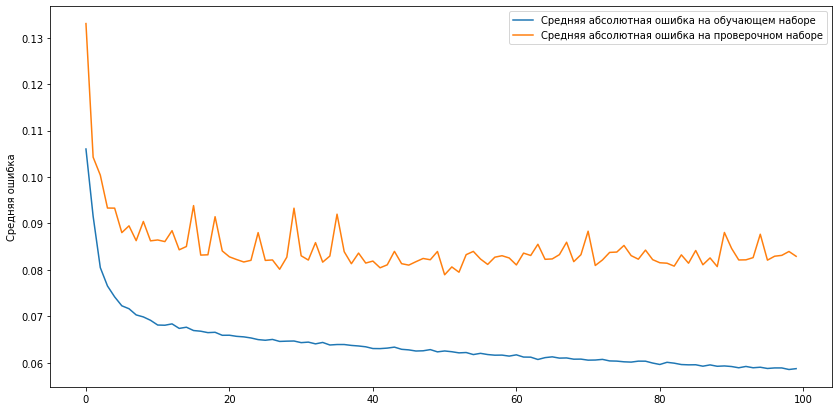

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0],yScaler) 

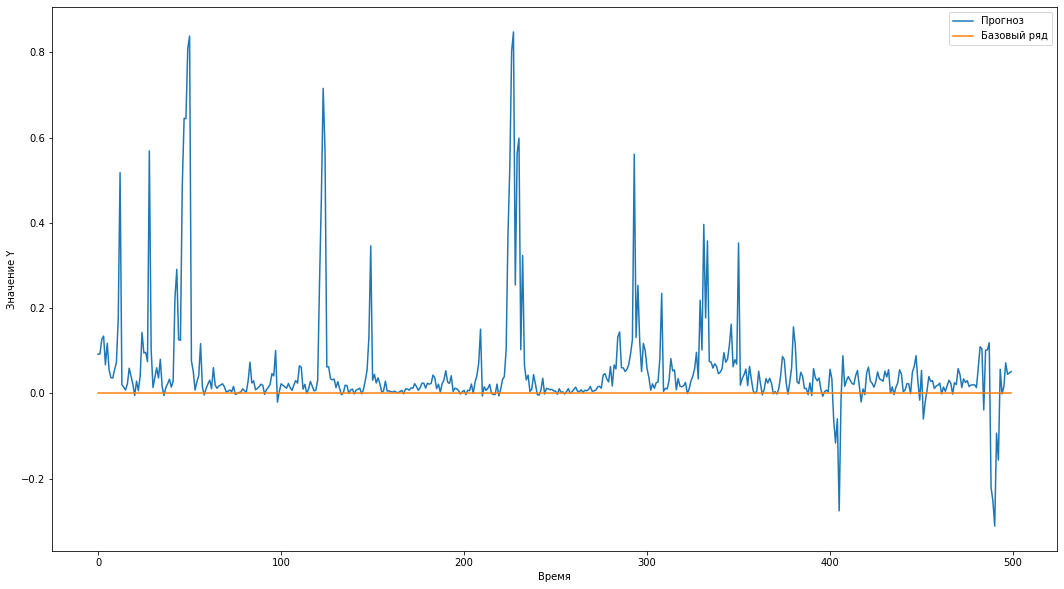

In [ ]:
# Отображаем графики
showPredict(0, 500, 0, predVal, yValUnscaled)

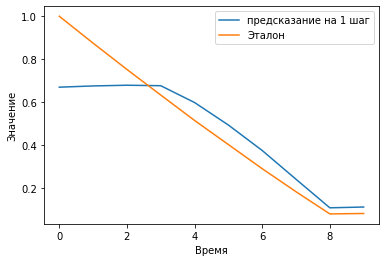

In [ ]:
autoCorr([0], 10, predVal, yValUnscaled)

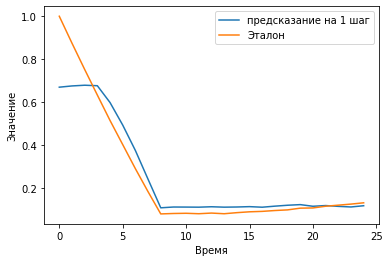

In [ ]:
autoCorr([0], 25, predVal, yValUnscaled)

In [ ]:
# Сохраняем/загружаем модель
model.save( PATH+ 'modelGA-TS-8.h5' )

!ls {PATH} 

# model = load_model(PATH+ 'modelGA-TS-8.h5')

'AK&VGG16'	   sample_submission.csv   train.csv
 Checkpoint.hdf5   test.csv		   true_values.npy
 modelGA-TS-8.h5  'Time series N->N+1'


**Пересчитаем предикт по порогу**

In [ ]:
predVal_2 = predVal.copy()
predVal_2[predVal>0.5] = 1
predVal_2[predVal<=0.5] = 0

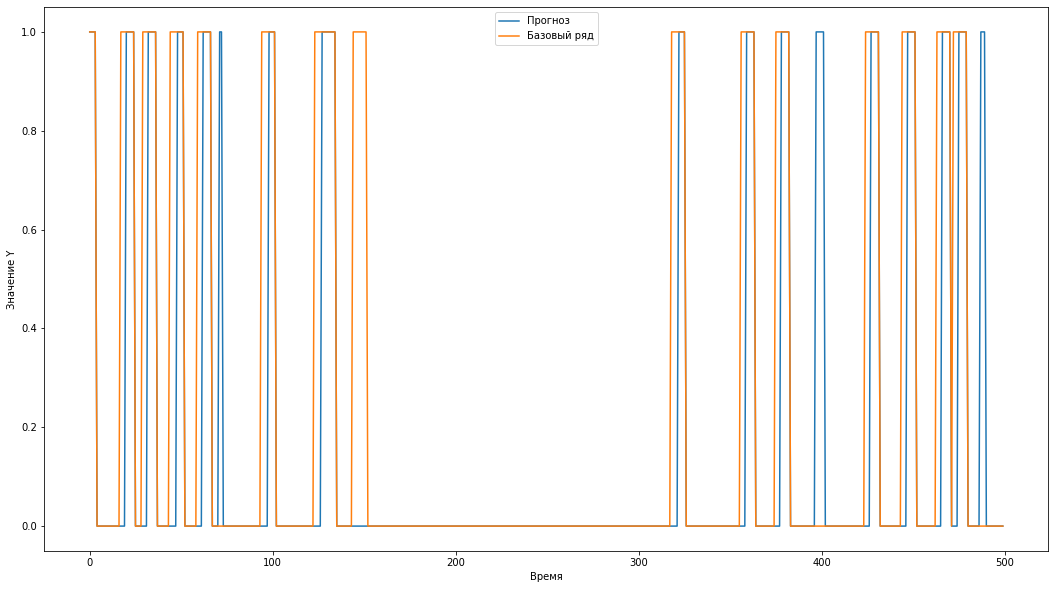

In [ ]:
# Отображаем графики
showPredict(1500, 500, 0, predVal_2, yValUnscaled)

**Посчитаем метрики**

In [ ]:
pred = predVal_2.astype(int)
yVal2 = yValUnscaled.astype(int)

In [ ]:
# точность f1
from sklearn.metrics import f1_score
f1 = f1_score(predVal_2, yVal2, average='micro', zero_division='warn')
f1

0.9057576625608709

In [ ]:
# точность f1
from sklearn.metrics import f1_score
f1 = f1_score(yVal2, pred, average='binary', zero_division='warn')
f1

0.674901185770751

In [ ]:
# Посчитаем accuracy и другие метрики
true_cov = 0
false_cov = 0
true_pur = 0
false_pur = 0

for i in range(pred.shape[0]):
  # предсказанный класс (классы 0 и 1)
  if pred[i][0]==0:
    curr_class = 0
  else:
    curr_class = 1
  # правильный класс
  true_class = yVal2[i][0]
  #
  if curr_class == 0:    # предсказали 0
    if true_class == 0:  
      true_pur += 1      # правильно предсказали 0
    else:
      false_pur += 1     # неправильно предсказали 0

  if curr_class == 1:    # предсказали 1 (ковид)
    if true_class == 1:  
      true_cov += 1      # правильно предсказали 1 (ковид)
    else:
      false_cov += 1     # неправильно предсказали 1 (ковид)


# Accuracy
accuracy = (true_pur + true_cov) / (true_pur+false_pur+true_cov+false_cov)
# Precision 
prec_pur = true_pur / (true_pur + false_pur)
prec_cov = true_cov / (true_cov + false_cov)
# Recall
recall_pur = true_pur / (true_pur + false_cov)
recall_cov = true_cov / (true_cov + false_pur)
#
print('Всего предсказаний =', true_pur+false_pur+true_cov+false_cov)
print('true pure', true_pur)
print('false pure', false_pur)
print('true covid', true_cov)
print('false covid', false_cov)
print()
print('Accuracy =', round(accuracy, 2))
print('Precision Covid =', round(prec_cov, 2))
print('Precision Pure =', round(prec_pur, 2))
print('Recall Covid =', round(recall_cov, 2))
print('Recall Pure =', round(recall_pur, 2))

Всего предсказаний = 6982
true pure 5641
false pure 522
true covid 683
false covid 136

Accuracy = 0.91
Precision Covid = 0.83
Precision Pure = 0.92
Recall Covid = 0.57
Recall Pure = 0.98
